# Car Price prediction 4_in_ONE

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

## Делаем следующее:
* Построим "наивную" модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем признаки, создадим несколько новых и сделаем нормализацию
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost и усилим ее кросс-валидацией
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно, для текста применим лемматизацию и токенизацию
* Добавим в multi-input сеть обработку изображений, используя методики Transfer-Learning и Fine-Tuning
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

За основу взят Baseline-ноутбук из курса SF

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
YEAR = 2021

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [10]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [11]:
train.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
4280,седан,BMW,серый,ID: 38742\n«МБ Измайлово» – официальный диле...,2.0 LTR,136 N12,бензин,241251,2008,3ER,...,539000.0,2011,1099684586,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
5975,седан,AUDI,коричневый,Продаю свой авто в связи с крайне редким испол...,1.8 LTR,120 N12,бензин,55000,2011,A4,...,950000.0,2014,1093102394,SEDAN VARIATOR 1.8,вариатор,2 владельца,NaN,Оригинал,передний,Левый
1452,внедорожник 5 дв.,AUDI,коричневый,"Автомобиль в идеальном состоянии не битый, не ...",2.0 LTR,225 N12,бензин,140135,2012,Q5,...,1050000.0,2013,1091088088,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,2 владельца,1 год и 11 месяцев,Оригинал,полный,Левый


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [12]:
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [13]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
#predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

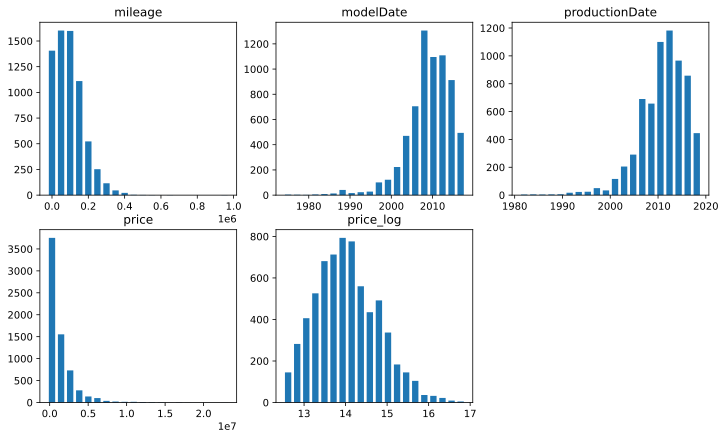

In [14]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 4, rows * 3.5))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    #ax.scatter(x = values, y = train['price'])
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna(), 
    'price': train['price'].dropna(), 
    'price_log': train['price'].apply(np.log),
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [15]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


### Создадим новые признаки, а их краткий анализ проведем ниже, после нормализации

In [16]:
# Данные очень чистые, пропущенные значения есть только в столбцах 'Владельцы' и 'Владение'
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [17]:
# Переделаем признак 'enginePower' в числовой
data['enginePower'] = data['enginePower'].apply(lambda x: int(x.split(' ')[0].replace('.', '')))

In [18]:
# Сделаем числовым 'engineDisplacement'
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: '2.0 LTR' if x == 'undefined LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: int(x.split(' ')[0].replace('.', '')))
data['engineDisplacement'].value_counts().head(3)

20    2436
30    2349
18     411
Name: engineDisplacement, dtype: int64

In [19]:
# Сдвинем даты относительно текущего года 
data['productionDate'] = data['productionDate'].apply(lambda x: YEAR - x)
data['modelDate'] = data['modelDate'].apply(lambda x: YEAR - x)

In [20]:
# Из числовых сделаем еще 3 новых признака:
# 'model_age' - новизна модели на момент производства с весом 0.1
data['model_age'] =  data['modelDate'] - data['productionDate']
data['model_age'] = data['model_age'].apply(lambda x: 0. if x < 0 else 0.1*x)

# 'km_pro_year' - cтепень эксплуатации(пробег/год)
data['km_pro_year'] = data['mileage']/(YEAR - data['productionDate'])

# 'mil_p' - отношение логарифма пробега к мощности
data['mil_p'] = data['mileage'].apply(lambda x: np.log(1. + x))/data['enginePower']

In [21]:
# Признак 'Владение' вряд ли является значимым и имеет 2/3 пропусков, но 
# является интересным в плане обработки, поэтому не выбрасываем его
data['Владение'].isna().value_counts()

True     5418
False    2935
Name: Владение, dtype: int64

In [22]:
# 'Владельцы' пока переделаем в числовой, чтобы рассчитать 'Владение',
# но позже обработаем его как категориальный
data['Владельцы'].fillna(data['Владельцы'][150], inplace=True)
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(x[0]))
data['Владельцы'].value_counts()

3    3311
1    2526
2    2516
Name: Владельцы, dtype: int64

In [23]:
# 'Владение' в месяцах вычисляем где есть из текста, а пропущенные заменяем на
# возраст/кол-во владельцев
def own(x):    
    ''' extracts time in months from "Владение"'''
    
    try:
        pattern_year = re.compile('\d+ [гл]')
        pattern_month = re.compile('\d+ [м]')
        own_year = pattern_year.findall(x['Владение'])
        own_month = pattern_month.findall(x['Владение'])
        own_year.append('0')   # чтобы не было пустого списка
        own_month.append('0')
        return (float(own_year[0].split(' ')[0])*12 + float(own_month[0].split(' ')[0]))
    
    except:
        return x['productionDate']*12/x['Владельцы']

In [24]:
# Применяем ф-цию 
data['Владение'] = data.apply(lambda data: own(data), axis=1)
data['Владение'].value_counts().head()

36.0    623
24.0    574
48.0    529
60.0    406
72.0    274
Name: Владение, dtype: int64

In [25]:
# Используем текстовые признаки как категориальные без предобработки,
# за исключением 'name' и 'vehicleConfiguration' 
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'Владельцы', 
                        'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль']

# числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 'enginePower', 'engineDisplacement', 
                      'model_age', 'km_pro_year', 'mil_p', 'Владение']

In [26]:
# Пропущенных значений в числовых признаках нет
data[numerical_features].isna().value_counts()

mileage  modelDate  productionDate  enginePower  engineDisplacement  model_age  km_pro_year  mil_p  Владение
False    False      False           False        False               False      False        False  False       8353
dtype: int64

In [27]:
# В категориальных признаках тоже нет пропущенных значений
data[categorical_features].isna().value_counts()

bodyType  brand  color  fuelType  model_info  Владельцы  numberOfDoors  vehicleTransmission  ПТС    Привод  Руль 
False     False  False  False     False       False      False          False                False  False   False    8353
dtype: int64

In [28]:
# Посмотрим, что можно извлечь из этих признаков
data[['name', 'vehicleConfiguration']].sample(5)

,name,vehicleConfiguration
5404,250 2.0 AMT (211 л.с.) 4WD,ALLROAD_5_DOORS ROBOT 2.0
3613,325xi 2.5 AT (218 л.с.) 4WD,COUPE AUTOMATIC 2.5
7634,1.8 AMT (190 л.с.),SEDAN ROBOT 1.8
6623,740Li xDrive 3.0 AT (320 л.с.) 4WD,SEDAN AUTOMATIC 3.0
5221,750i xDrive 4.4 AT (450 л.с.) 4WD,SEDAN AUTOMATIC 4.4


In [29]:
# Создадим признак 'allroad' для авто с полным приводом, используя данные из обоих столбцов
allroad1 = data['vehicleConfiguration'].apply(lambda x: 1 if 'ALLROAD' in x.split('_') else 0)
allroad2 = data['name'].apply(lambda x: 1 if '4WD' in x.split(' ') else 0)
data['allroad'] = (allroad1 + allroad2).apply(lambda x: 0 if x == 0 else 1)
categorical_features.append('allroad')
data['allroad'].value_counts()

1    5306
0    3047
Name: allroad, dtype: int64

In [30]:
'''# Укоротим признак 'name' до последней 'T', тогда в нем останется 566 вместо 900 уникальных значений
pattern = re.compile('.*T')
data['name_short'] = data['name'].apply(lambda x: pattern.findall(x)[0])
categorical_features.append('name_short')
data['name_short'].value_counts()'''

"# Укоротим признак 'name' до последней 'T', тогда в нем останется 566 вместо 900 уникальных значений\npattern = re.compile('.*T')\ndata['name_short'] = data['name'].apply(lambda x: pattern.findall(x)[0])\ncategorical_features.append('name_short')\ndata['name_short'].value_counts()"

In [31]:
# Выделим AMG, Maybach и BMW-M как наиболее дорогие
data['lux'] = data['model_info'].apply(lambda x: 1 if (x != 'M_KLASSE') & ('M' in x) else 0)
categorical_features.append('lux')
data[data['lux'] == 1].model_info.value_counts().head()

G_KLASSE_AMG       71
S_KLASSE_AMG       65
X6_M               61
S_CLASS_MAYBACH    45
E_KLASSE_AMG       44
Name: model_info, dtype: int64

In [32]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # убираем ненужные для модели признаки
    df_output.drop(['description', 'sell_id', 'name', 'vehicleConfiguration'], axis = 1, inplace=True)
    
    # Нормализация данных
    scaler = MinMaxScaler()    
    for column in numerical_features:        
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]          
       
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
           
    return df_output

In [33]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)

In [34]:
df_preproc.sample(3)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,sample,price,model_age,km_pro_year,...,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,allroad_0,allroad_1,lux_0,lux_1
4104,0.389831,0.2784,0.022254,0.020833,0.026316,0.051919,1,5999000.0,0.055556,0.021978,...,1,0,0,1,1,0,0,1,1,0
4049,0.389831,0.4240,0.006280,0.020833,0.026316,0.051919,1,7450000.0,0.055556,0.006202,...,1,0,0,1,1,0,0,1,1,0
6886,0.220339,0.1680,0.062488,0.166667,0.157895,0.153499,1,1250000.0,0.166667,0.061868,...,1,0,1,0,1,0,1,0,1,0


## Split data

In [35]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values
y_log = np.log(y)    # логарифмируем целевую, это улучшает результат Catboost
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

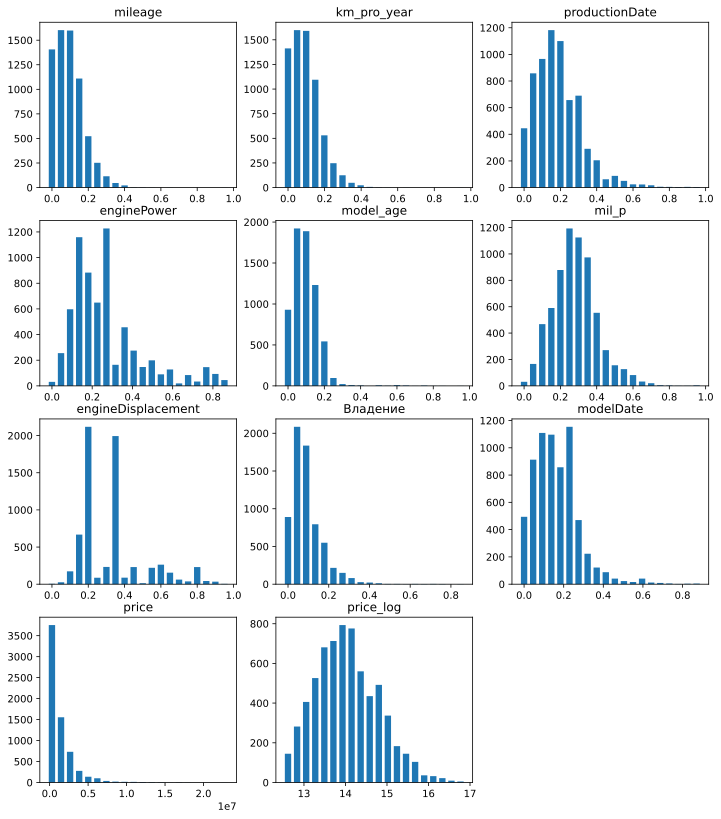

In [36]:
# Посмотрим гистограммы числовых признаков
visualize_distributions({'mileage': train_data['mileage'], 'km_pro_year': train_data['km_pro_year'], 'productionDate': train_data['productionDate'], 
                         'enginePower': train_data['enginePower'], 'model_age': train_data['model_age'], 'mil_p': train_data['mil_p'], 
                        'engineDisplacement': train_data['engineDisplacement'], 'Владение': train_data['Владение'], 'modelDate': train_data['modelDate'], 
                        'price': train_data['price'], 'price_log': train_data['price'].apply(np.log)})

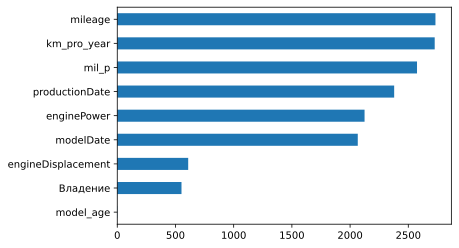

In [37]:
# Проверим их значимость
nums = pd.Series(f_regression(train_data[numerical_features], train_data['price'])[0], index = numerical_features)
nums.sort_values(inplace = True)
nums.plot(kind = 'barh')

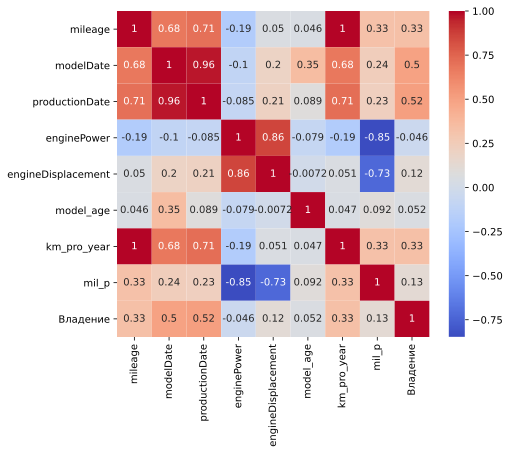

In [38]:
# И корреляцию
import seaborn as sns
correlation = train_data[numerical_features].corr()
plt.figure(figsize=(7, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

## Итоги EDA и Feature Engineering:
* Вместе с созданными имеем 9 числовых и 11 категориальных признаков
* Распределены признаки по-разному, у объёма двигателя, например, есть явно выраженная двойная вершина  
* В основном распределения имеют пологий правый хвост, поэтому для нейросетей имеет смысл логарифмировать признаки
* Из числовых самые значимые - пробег, дата производства и пара созданных
* Наблюдаем сильную корреляцию между несколькими числ. признаками, но оставляем их все, т.к. тогда результат CatBoost'а лучше

In [39]:
#sys.exit()

SystemExit: 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Model 2: CatBoostRegressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
model = CatBoostRegressor(iterations = 20000,
                          depth=8,
                          learning_rate = 0.01,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=1000,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         #plot=True
         )

In [ ]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.4f}%")

In [ ]:
# для контроля посмотрим MAPE в обычном масштабе
test_predict_catboost_reg = np.exp(test_predict_catboost)
y_test_reg = np.exp(y_test)
print(f"TEST mape: {(mape(y_test_reg, test_predict_catboost_reg))*100:0.4f}%")

#### CatBoost дает MAPE = 10.87% - весьма неплохой результат

In [ ]:
#sys.exit()

### Submission

In [ ]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission['price'] = np.round(sample_submission['price'].apply(lambda x: math.exp(x)).values, 0)
sample_submission.to_csv('catboost_submission.csv', index=False)

### CatBoost + CV

Сделаем кросс-валидацию для улучшения результата  

In [ ]:
X_cv = train_data.drop(['price'], axis=1).values
X_pred_cv = test_data.drop(['price'], axis=1).values

In [ ]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = 20000,
                              depth = 8,
                              learning_rate = 0.01,
                              eval_metric='MAPE',
                              custom_metric=['RMSE','MAPE'],
                              od_wait = 1000,
                              random_seed = RANDOM_SEED,)
    model.fit(X_train, y_train,
              #cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)

In [ ]:
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

In [ ]:
N_FOLDS = 10
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X_cv,y_log))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    Xf_train, yf_train, Xf_test, yf_test = X_cv[train_idx], y_log[train_idx], X_cv[test_idx], y_log[test_idx]
    # model for this fold
    model = cat_model(yf_train, Xf_train, Xf_test, yf_test)
    # score model on test
    test_predict = model.predict(Xf_test)
    test_score = mape(yf_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(yf_test, test_predict)*100:0.4f}%")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_pred_cv)
    # model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls)*100:0.4f}%')
print(f'Std Score: {np.std(score_ls)*100:0.4f}%')
print(f'Max Score: {np.max(score_ls)*100:0.4f}%')
print(f'Min Score: {np.min(score_ls)*100:0.4f}%')

In [ ]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = np.round(submissions['blend'].apply(lambda x: math.exp(x)).values, 0)
sub_predict_catboost_cv = sample_submission['price']
sample_submission.to_csv('catboost_cv_submission.csv', index=False)
sample_submission.head(3)

In [ ]:
# Stop
#sys.exit()

# Model 3: Tabular NN

Построим простую нейросеть для регрессии, состоящую из трех плотных слоёв     
Признаки логарифмируем, а целевую переменную, наоборот, оставляем, как в исходных данных

In [40]:
for column in numerical_features:
    X[column] = X[column].apply(lambda x: np.log(x + 0.1))
    X_sub[column] = X_sub[column].apply(lambda x: np.log(x + 0.1))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Simple Dense NN

In [ ]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=20, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=1000, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.save('../working/nn_1.hdf5')

In [ ]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

#### Simple Dense NN дает в среднем MAPE = 11.25% 

In [ ]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

In [ ]:
# Stop
#sys.exit()

### Model 4: NLP + Multiple Inputs

In [42]:
# В описаниях находим 5 пустых значений и заменяем их на подобные
data['description_1'] = data['description'].apply(lambda x: len(x))
data[data['description_1'] == 1]['description']

388       
1005     .
4265    \n
6381     .
8283     Ц
Name: description, dtype: object

In [43]:
data['description'].loc[388] = data['description'].loc[7069]
data['description'].loc[1005] = data['description'].loc[4753]
data['description'].loc[4265] = data['description'].loc[7448]
data['description'].loc[6381] = data['description'].loc[3004]
data['description'].loc[8283] = data['description'].loc[8349]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [44]:
# Добавим для информативности в описания данные из других колонок
data.description = data.brand + ' ' + data.bodyType + ' ' +\
                   data.enginePower.apply(lambda x: str(x)) +  ' ' + 'лс' + ' ' +\
                   data.productionDate.apply(lambda x: str(x)) + ' ' + 'год' + ' ' + data.description  

In [45]:
# Сделаем лемматизацию и уберем стоп-слова из текстов объявлений
!pip install pymystem3

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

# Исключим из стоп-листа 'не'
operators = set(('не', 'не'))
russian_stopwords = set(russian_stopwords) - operators

def lemma_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

#Example    
lemma_text("Машина тут продаётся не в первый раз, НО!")

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


'машина продаваться не первый'

In [47]:
# Благодаря лемматизации кол-во токенов в словаре tokenize.word_index
# уменьшается с 39591 до 22500
data.description = data.description.apply(lambda x: lemma_text(x))
data.description[17]

'bmw внедорожник 5 дв 218 лс 5 год продажа автомобиль компания ао abtodom официальный дилер bmw mini bmw i bmw motorrad mercedes benz smart lamborghini автомобиль ваш удобство находиться тепло паркинг 200 автомобиль пробег крыша готовый предлагать автомобиль пробег официальный дилер abtodom внуково наш склад 200 автомобиль срочный выкуп день день abtodom внуково  –  официальный дилерский центр bmw mini входить состав гк abtodom  –  являться крупный игрок российский авторитейл состав гк abtodom входить бренд bmw mini bmw i bmw motorrad mercedes benz smart audi volvo jaguar land rover ducati lamborghini 15 дилерский центр москва санкт петербург автомобиль проходить полный технический диагностика официальный дилер технический диагностика  –  это комплексный проверка состояние весь наш автомобиль весь результат диагностика мочь подробно ознакомляться салон кузов лакокрасочный покрытие проверять специализированный оборудование автомобиль проходить полный юридический проверка официальный дил

In [48]:
# TOKENIZER
# The maximum number of words to be used
MAX_WORDS = 50000
# Max number of words in each complaint
MAX_SEQUENCE_LENGTH = 256

In [49]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [50]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.67 s, sys: 0 ns, total: 1.67 s
Wall time: 1.67 s


In [51]:
tokenize.word_index

{'•': 1,
 'автомобиль': 2,
 'год': 3,
 'не': 4,
 'система': 5,
 'лс': 6,
 'пробег': 7,
 'задний': 8,
 'салон': 9,
 'bmw': 10,
 'сидение': 11,
 'весь': 12,
 '5': 13,
 'состояние': 14,
 'передний': 15,
 'машина': 16,
 '2': 17,
 'mercedes': 18,
 'диск': 19,
 'комплект': 20,
 'седан': 21,
 'дилер': 22,
 'дв': 23,
 'новый': 24,
 'официальный': 25,
 'ваш': 26,
 'кредит': 27,
 'фара': 28,
 'внедорожник': 29,
 'авто': 30,
 'гарантия': 31,
 'пакет': 32,
 'руль': 33,
 'колесо': 34,
 'audi': 35,
 'безопасность': 36,
 'комплектация': 37,
 '000': 38,
 '6': 39,
 'обмен': 40,
 'контроль': 41,
 'птс': 42,
 'зеркало': 43,
 'проверка': 44,
 '3': 45,
 'покупка': 46,
 'продажа': 47,
 'водитель': 48,
 'полный': 49,
 '9': 50,
 '1': 51,
 'шина': 52,
 'датчик': 53,
 'отличный': 54,
 'пассажир': 55,
 'двигатель': 56,
 'резина': 57,
 'владелец': 58,
 'условие': 59,
 'ключ': 60,
 '«': 61,
 'кузов': 62,
 'подушка': 63,
 'продавать': 64,
 'подогрев': 65,
 'технический': 66,
 'обогрев': 67,
 'любой': 68,
 'хороший'

In [52]:
len(tokenize.word_index)

22500

In [53]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.66 s, sys: 0 ns, total: 1.66 s
Wall time: 1.66 s


In [54]:
# вот так теперь выглядит наш текст
print(text_train.iloc[17])
print(text_train_sequences[17])

bmw кабриолет 192 лс 28 год долго описывать интересоваться рассказывать телефон s52b32 usa акпп выхлоп задний мост тормоз вкуругий контрактный пробег 150 тыс км свап лето 2019 полный покраска зима 2018 2019 замена большинство кузовной запчасть кузов отличный состояние авария рожь новый тент красный хардтоп комплект новый оригинальный черный ковер вэйдер черный кожа очень редкий ветровик paul klee хороший музыка скрытый установка bbc rc r18 новый резина резина летний зима не эксплуатироваться пневмоподвеска управление accuair e level передний стойка сбор airlift сзади подушка airlift короткий стойка задний регулировать развальный рычаг bb ничто не стучать не греметь весь резинка новый либо полиуретан powerflex ),  либо м3 подробность телефон весь строить ноль машина знать очень новый оригинал собираться колхоз документ вина 325 кабриолет готовый расставаться пока продажа интересовать авто
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0  

### RNN NLP

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH, name='nlp1'))
model_nlp.add(L.LSTM(256, return_sequences=True, name='nlp2'))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128, name='nlp3'))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu", name='nlp4'))
model_nlp.add(L.Dropout(0.25))

### MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu", name='mlp1'))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu", name='mlp2'))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output], name='comb1')
# being our regression head
head = L.Dense(256, activation="relu", name='comb2')(combinedInput)
head = L.Dense(1, activation="linear", name='comb3')(head)

model_1 = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head, name='model_1')

In [ ]:
model.summary()

### Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model_1.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=20, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model_1.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model_1.save('../working/nn_mlp_nlp.hdf5')

In [ ]:
test_predict_nn2 = model_1.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

#### MLP+NLP дает в среднем MAPE = 11.20% 

In [ ]:
sub_predict_nn2 = model_1.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

In [ ]:
# Пробовал подгружать предобученную в этой части модель в следующую, тройную, но положительного эффекта не заметил

'''assert(model_1.layers[-3].name=='comb1')
model_1_headless = Model(inputs=[model_nlp.input, model_mlp.input], outputs=model_1.layers[-3].output, name='model_1')
optimizer = tf.keras.optimizers.Adam(0.005)
model_1_headless.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
model_1_headless.load_weights('../working/nn_mlp_nlp.hdf5',  by_name=True)'''

# Model 5: Добавляем картинки

### Data

In [ ]:
# Stop
#sys.exit()

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

### albumentations

In [ ]:
# Для аугментации используем Albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, RandomShadow, 
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

augmentation = Compose([
    HorizontalFlip(p=0.4),
    OneOf([
        RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15),
        RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05)
    ],p=0.3),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.45),
    Blur(p=0.15),
    HueSaturationValue(p=0.25),
    #RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, always_apply=False, p=0.25),
])

#пример
plt.figure(figsize = (12,8))
for i in range(12):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [ ]:
# Используем предобученную EfficientNetB6
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB6(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [ ]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [ ]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [ ]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

### Step 1. No EfficientNet

In [ ]:
# Не тренируем часть с картинками
efficientnet_model.trainable = False

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=20,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

In [ ]:
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

### Step 2. 50% EfficientNet

In [ ]:
efficientnet_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(efficientnet_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False
len(efficientnet_model.trainable_variables)

In [ ]:
model.load_weights('../working/best_model.hdf5')

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=20,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

In [ ]:
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

### Step 3. 100% EfficientNet

In [ ]:
efficientnet_model.trainable = True
len(efficientnet_model.trainable_variables)

In [ ]:
model.load_weights('../working/best_model.hdf5')

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit(train_dataset.batch(20),
                    epochs=5,
                    validation_data = test_dataset.batch(20),
                    callbacks=callbacks_list
                   )

In [ ]:
model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

### Step 4. 100% EfficientNet + Big Images

In [ ]:
# Увеличиваем размер подаваемых изображений
input_shape_efn = (480, 360, 3)
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB6(weights = 'imagenet', include_top = False, input_shape = input_shape_efn)
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [ ]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

In [ ]:
model.load_weights('../working/best_model.hdf5')

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit(train_dataset.batch(18),
                    epochs=5,
                    validation_data = test_dataset.batch(18),
                    callbacks=callbacks_list
                   )

In [ ]:
model.save('../working/nn_final.hdf5')

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = np.round(sub_predict_nn3[:,0], 0)
sample_submission.to_csv('nn3_submission.csv', index=False)
sample_submission.head(3)

## Итоги работы 3-х видов нейросетей:
* С увеличением сложности нейросети результат улучшался с 11.25(простая плотная сеть) до 10.85(тройная сеть+Big Images)
* LR подбирался в ручном режиме, с оптимизатором не экспериментировал   
* Время обсчитывания одной эпохи на высоких уровнях сложности достигало 4 мин
* Пробовал прикреплять предобученную часть MLP+NLP к тройной - без видимого улучшения
* Думаю, что есть резерв для развития в NLP-части

# Blend

#### Объединение результатов ML и DL существенно повышает точность

In [ ]:
# Stop
#sys.exit()

In [ ]:
blend_predict = (test_predict_catboost_reg + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

In [ ]:
blend_sub_predict = round((sub_predict_catboost_cv + sub_predict_nn3[:,0]) / 2, 0)
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

In [ ]:
sample_submission.head(3)

#### Итоговый результат на Leaderboard: 10.756,  3-е место на текущий момент